## **Práctica 1: MLLIB CON DATASET DE RETRASOS DE VUELOS**

### 1. Carga de datos

Importamos las librerías necesarias

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, RobustScaler, UnivariateFeatureSelector, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, MultilayerPerceptronClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


Creamos la sesión de Spark

In [ ]:
# Ruta Andrés
# os.environ['JAVA_HOME'] = 'C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot'
# Ruta Vila
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home'
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = SparkSession.builder \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

25/10/19 16:54:36 WARN Utils: Your hostname, MacBook-Air-de-Miguel.local resolves to a loopback address: 127.0.0.1; using 192.168.1.88 instead (on interface en0)
25/10/19 16:54:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/19 16:54:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Cargamos los datos con Pyspark y mostramos las primeras 5 filas

In [21]:
# Carga de datos con Pyspark

df = spark.read.csv('full_data_flightdelay.csv', header=True, inferSchema=True)
df.show(5)

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------

### 2. Análisis exploratorio de datos (EDA)

Mostramos el tipo de dato de cada columna

In [4]:
# Mostramos los tipos de datos de cada columna (schema)

df.printSchema()

root
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_DEL15: integer (nullable = true)
 |-- DEP_TIME_BLK: string (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- SEGMENT_NUMBER: integer (nullable = true)
 |-- CONCURRENT_FLIGHTS: integer (nullable = true)
 |-- NUMBER_OF_SEATS: integer (nullable = true)
 |-- CARRIER_NAME: string (nullable = true)
 |-- AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRPORT: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRLINE: integer (nullable = true)
 |-- FLT_ATTENDANTS_PER_PASS: double (nullable = true)
 |-- GROUND_SERV_PER_PASS: double (nullable = true)
 |-- PLANE_AGE: integer (nullable = true)
 |-- DEPARTING_AIRPORT: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- PREVIOUS_AIRPORT: stri

Dimensiones del dataset

In [5]:
# Mostramos número de filas y columnas

print('Número de filas:', df.count())
print('Número de columnas:', len(df.columns))

Número de filas: 6489062
Número de columnas: 26


Distribución de la variable objetivo (retraso o no retraso)

In [6]:
# Mostramos cuantos vuelos llegaron con retraso (DEP_DEL15 = 1) y cuantos no (DEP_DEL15 = 0)

df.groupBy('DEP_DEL15').count().show()

+---------+-------+
|DEP_DEL15|  count|
+---------+-------+
|        1|1227368|
|        0|5261694|
+---------+-------+



Estudio de valores nulos por columna

In [ ]:
# Miramos si existen valores nulos en cada columna, sin importar el tipo de dato

null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+-----------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+-----------------------

- **Conclusión**: No hay nulos en ninguna de las columnas.

Análisis estadístico descriptivo de todas las variables (interesante sobre todo en las numéricas)

In [9]:
# Hacemos un Análisis Estadístico Descriptivo

df.summary().show()

+-------+------------------+------------------+-------------------+------------+------------------+------------------+------------------+------------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+------------------+-----------------+-----------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|             MONTH|       DAY_OF_WEEK|          DEP_DEL15|DEP_TIME_BLK|    DISTANCE_GROUP|    SEGMENT_NUMBER|CONCURRENT_FLIGHTS|   NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|         PLANE_AGE|DEPARTING_AIRPORT|         LATITUDE|         LONGITUDE|    PREVIOUS_AIRPORT|               PRCP

Conteo de valores únicos en las variables categóricas

In [5]:
# Contamos cuantos valores diferentes hay en cada columna categórica
categorical_columns = ["DEP_TIME_BLK", "CARRIER_NAME", "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT"]

for column in categorical_columns:
    distinct_count = df.select(column).distinct().count()
    print(f"Columna '{column}' tiene {distinct_count} valores distintos.")

Columna 'DEP_TIME_BLK' tiene 19 valores distintos.
Columna 'CARRIER_NAME' tiene 17 valores distintos.
Columna 'DEPARTING_AIRPORT' tiene 96 valores distintos.
Columna 'PREVIOUS_AIRPORT' tiene 356 valores distintos.


Distribución de las variables categóricas

In [ ]:
# Miramos la distribución de las variables categóricas

for column in categorical_columns:
    print(f"Distribución de la columna '{column}':")
    df.groupBy(column).count().orderBy('count', ascending=False).show(5)  # Mostramos los 10 más comunes

Distribución de la columna 'DEP_TIME_BLK':
+------------+------+
|DEP_TIME_BLK| count|
+------------+------+
|   0800-0859|452391|
|   0700-0759|436032|
|   0600-0659|430404|
|   1700-1759|408878|
|   1200-1259|398009|
+------------+------+
only showing top 5 rows
Distribución de la columna 'CARRIER_NAME':
+--------------------+-------+
|        CARRIER_NAME|  count|
+--------------------+-------+
|Southwest Airline...|1296329|
|Delta Air Lines Inc.| 938346|
|American Airlines...| 903640|
|United Air Lines ...| 601044|
|SkyWest Airlines ...| 584204|
+--------------------+-------+
only showing top 5 rows
Distribución de la columna 'DEPARTING_AIRPORT':
+--------------------+------+
|   DEPARTING_AIRPORT| count|
+--------------------+------+
|   Atlanta Municipal|392603|
|Chicago O'Hare In...|329045|
|Dallas Fort Worth...|296449|
|Stapleton Interna...|247175|
|   Douglas Municipal|231855|
+--------------------+------+
only showing top 5 rows
Distribución de la columna 'PREVIOUS_AIRPORT':


Distribución de la variable objetivo respecto a otras variables (numéricas y categóricas)

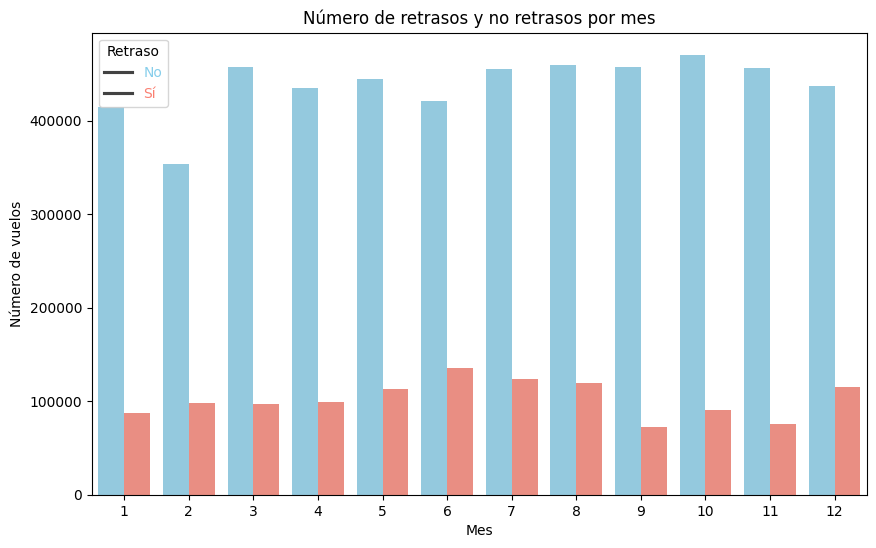

In [ ]:
# Comparamos el número de retrasos y no retrasos por mes

df_grouped = (df.groupBy("MONTH", "DEP_DEL15").count().orderBy("MONTH"))

df_pandas = df_grouped.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_pandas, x="MONTH", y="count", hue="DEP_DEL15", palette=["skyblue", "salmon"])
plt.title("Número de retrasos y no retrasos por mes")
plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.legend(title="Retraso", labels=["No", "Sí"], labelcolor=["skyblue", "salmon"])
plt.show()

- **Conclusión**: Parece que hay más proporción de retrasos en verano y diciembre

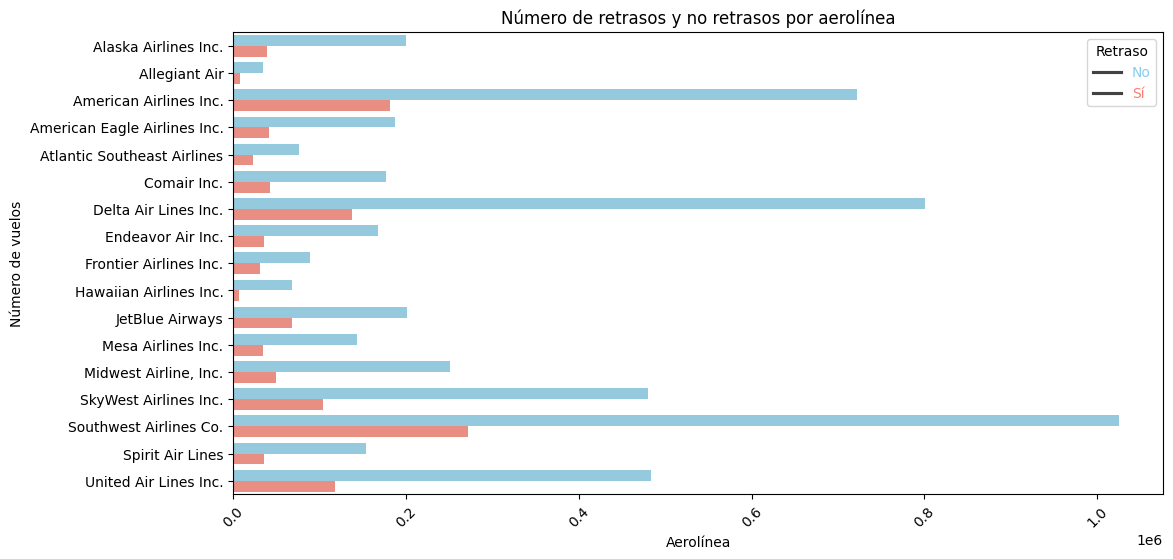

In [11]:
# Comparamos los vuelos con y sin retraso en cada aerolínea

df_grouped_airline = (df.groupBy("CARRIER_NAME", "DEP_DEL15").count().orderBy("CARRIER_NAME"))
df_pandas_airline = df_grouped_airline.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_pandas_airline, y="CARRIER_NAME", x="count", hue="DEP_DEL15", palette=["skyblue", "salmon"])
plt.title("Número de retrasos y no retrasos por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Número de vuelos")
plt.legend(title="Retraso", labels=["No", "Sí"], labelcolor=["skyblue", "salmon"])
plt.xticks(rotation=45)
plt.show()

- **Conclusión**: El número de vuelos retrasados parece más relacionado con la cantidad de vuelos de la aerolínea, se mantiene más o menos la proporción en todas las aerolíneas.

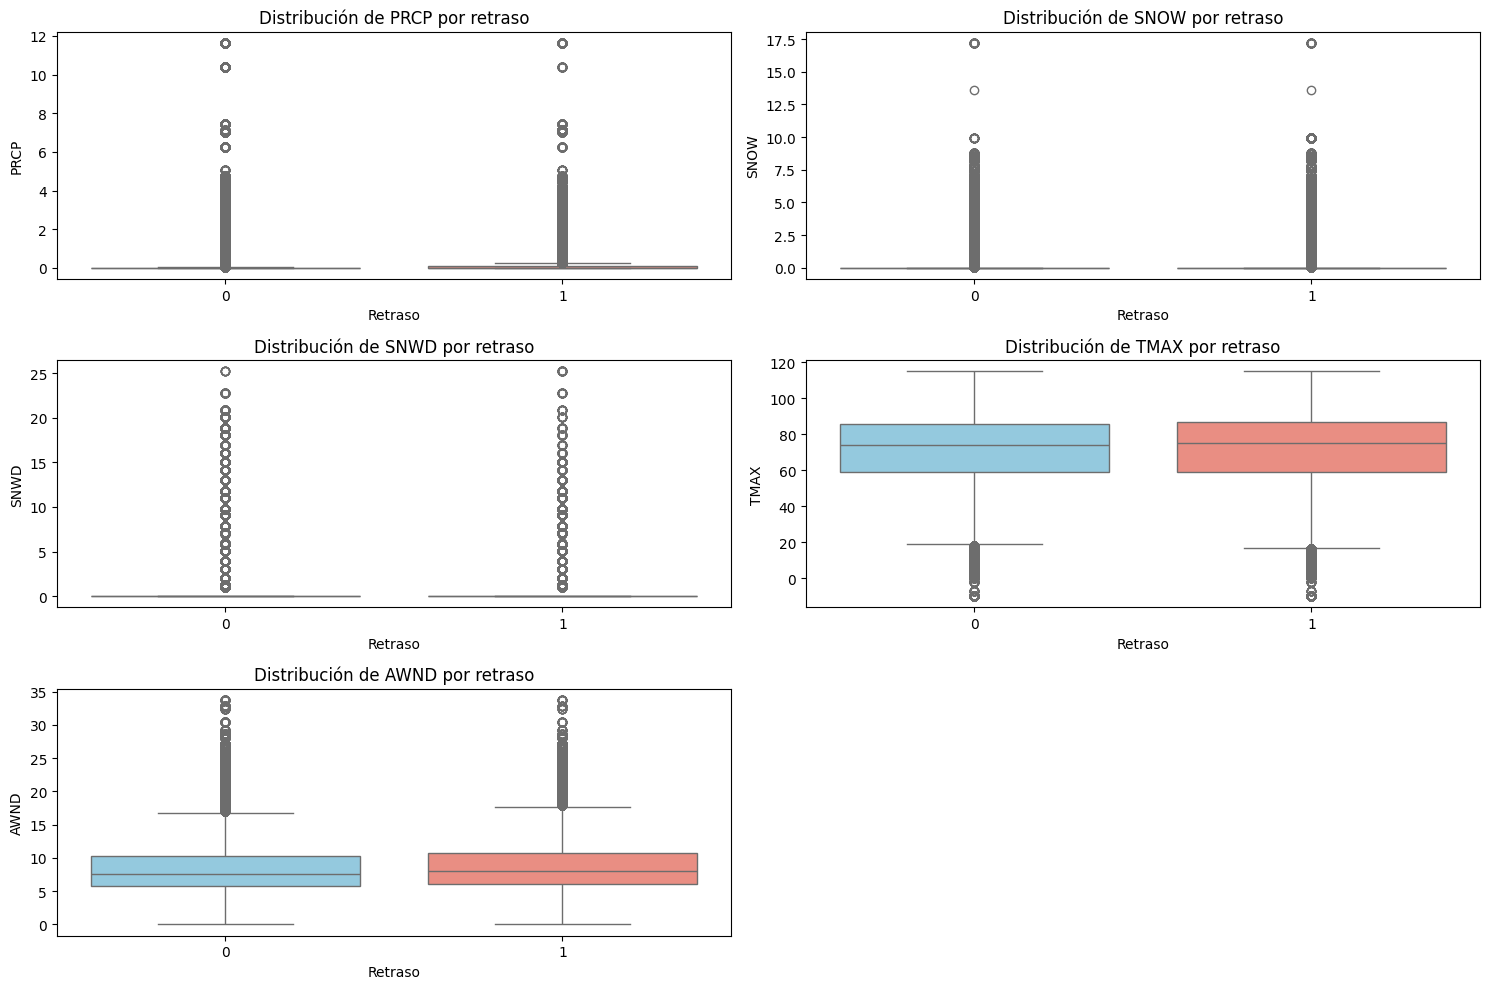

In [12]:
# Hacemos un análisis entre los retrasos y no con las variables relacionadas con la climatología (PRCP, SNOW, SNWD, TMAX, AWND)

df_weather = df.select("PRCP", "SNOW", "SNWD", "TMAX", "AWND", "DEP_DEL15")
df_weather_pandas = df_weather.toPandas()

plt.figure(figsize=(15, 10))
for i, column in enumerate(df_weather_pandas.columns[:-1], 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df_weather_pandas, x="DEP_DEL15", y=column, palette=["skyblue", "salmon"], hue="DEP_DEL15", legend=False)
    plt.title(f"Distribución de {column} por retraso")
    plt.xlabel("Retraso")
    plt.ylabel(column)
plt.tight_layout()
plt.show()

In [8]:
# Hacemos una tabla con la media de las variables meteorológicas agrupadas por retraso o no retraso con el df de spark
df_weather_grouped = df.groupBy("DEP_DEL15").mean("PRCP", "SNOW", "SNWD", "TMAX", "AWND")
df_weather_grouped.show()

+---------+-------------------+--------------------+-------------------+-----------------+-----------------+
|DEP_DEL15|          avg(PRCP)|           avg(SNOW)|          avg(SNWD)|        avg(TMAX)|        avg(AWND)|
+---------+-------------------+--------------------+-------------------+-----------------+-----------------+
|        1|0.16075319708514715|  0.0645147176722872|0.13091542226944045|71.12887528434835| 8.72188108212017|
|        0| 0.0903992668520658|0.023913648342149194|0.08233532774806152|71.54767504533694|8.252559113087262|
+---------+-------------------+--------------------+-------------------+-----------------+-----------------+



- **Conclusión**: La temperatura máxima parece no explicar los retrasos pero el resto de variables meteorológicas sí parecen tener cierta relación con los retrasos.

In [10]:
numerical_columns = ["DISTANCE_GROUP", "SEGMENT_NUMBER", "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS",
                     "AIRPORT_FLIGHTS_MONTH", "AIRLINE_FLIGHTS_MONTH", "AIRLINE_AIRPORT_FLIGHTS_MONTH", "AVG_MONTHLY_PASS_AIRPORT",
                     "AVG_MONTHLY_PASS_AIRLINE", "FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS"]

# Usamos el desempaquetado * para pasar la lista como argumentos posicionales.
df_numerical_grouped = df.groupBy("DEP_DEL15").mean(*numerical_columns)
df_numerical_grouped.show()

+---------+-------------------+-------------------+-----------------------+--------------------+--------------------------+--------------------------+----------------------------------+-----------------------------+-----------------------------+----------------------------+-------------------------+
|DEP_DEL15|avg(DISTANCE_GROUP)|avg(SEGMENT_NUMBER)|avg(CONCURRENT_FLIGHTS)|avg(NUMBER_OF_SEATS)|avg(AIRPORT_FLIGHTS_MONTH)|avg(AIRLINE_FLIGHTS_MONTH)|avg(AIRLINE_AIRPORT_FLIGHTS_MONTH)|avg(AVG_MONTHLY_PASS_AIRPORT)|avg(AVG_MONTHLY_PASS_AIRLINE)|avg(FLT_ATTENDANTS_PER_PASS)|avg(GROUND_SERV_PER_PASS)|
+---------+-------------------+-------------------+-----------------------+--------------------+--------------------------+--------------------------+----------------------------------+-----------------------------+-----------------------------+----------------------------+-------------------------+
|        1| 3.9014468358308183| 3.4746530787832173|        28.238819979012|  134.87901916947484| 

- **Conclusión**: La variable que más parece diferenciar entre vuelos con retraso y sin retraso es SEGMENT_NUMBER.

#### Reducción de datos con balanceo de clases

El dataset está desbalanceado, ya que la mayoría de los vuelos no tienen retraso (considerando retraso > 15 minutos).

Hacemos undersampling para balancear las clases y reducir el tamaño del dataset.

In [ ]:
df_delay = df.filter(df.DEP_DEL15 == 1)
df_no_delay = df.filter(df.DEP_DEL15 == 0)
df_no_delay = df.filter(df.DEP_DEL15 == 0).sample(False, df_delay.count() / df_no_delay.count(), seed=42)
df_balanced = df_delay.union(df_no_delay)

print('Número de filas después del balanceo:', df_balanced.count())
print("Número de vuelos con y sin retraso después del balanceo:")
print("Con retraso:", df_balanced.filter(df_balanced.DEP_DEL15 == 1).count())
print("Sin retraso:", df_balanced.filter(df_balanced.DEP_DEL15 == 0).count())

Número de filas después del balanceo: 2455100
Número de vuelos con y sin retraso después del balanceo:
Con retraso: 1227368
Sin retraso: 1227732


In [ ]:
# Guardamos el dataset balanceado en un nuevo archivo CSV
df_balanced.coalesce(1).write.csv('balanced_flightdelay_data.csv', header=True, mode='overwrite')

In [2]:
df_balanced = spark.read.csv('balanced_data_flightdelay.csv', header=True, inferSchema=True)

Comprobamos que los vuelos sin retraso mantengan su distribución al hacer el undersampling.

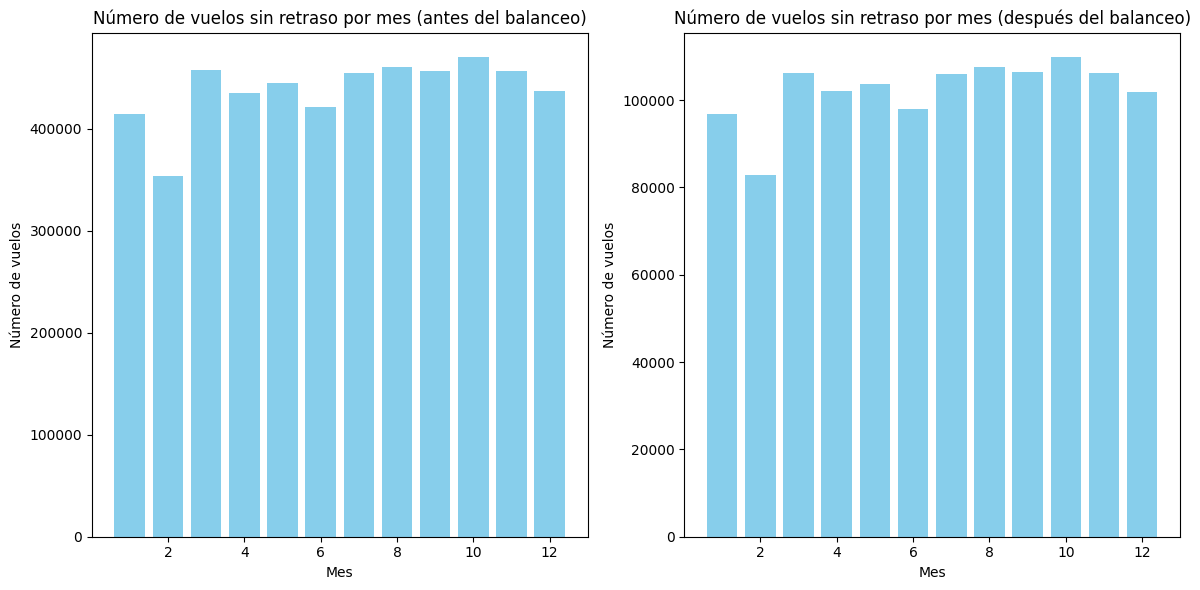

In [ ]:
# Comparamos el número de vuelos sin retraso por mes antes y después del balanceo

df_no_delay = df.filter(df.DEP_DEL15 == 0)
df_no_delay_grouped = df_no_delay.groupBy("MONTH").count().orderBy("MONTH")
df_no_delay_pandas = df_no_delay_grouped.toPandas()

df_no_delay_balanced = df_balanced.filter(df_balanced.DEP_DEL15 == 0)
df_no_delay_balanced_grouped = df_no_delay_balanced.groupBy("MONTH").count().orderBy("MONTH")
df_no_delay_balanced_pandas = df_no_delay_balanced_grouped.toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(df_no_delay_pandas["MONTH"], df_no_delay_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por mes (antes del balanceo)")
plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.subplot(1, 2, 2)
plt.bar(df_no_delay_balanced_pandas["MONTH"], df_no_delay_balanced_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por mes (después del balanceo)")
plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.tight_layout()
plt.show()

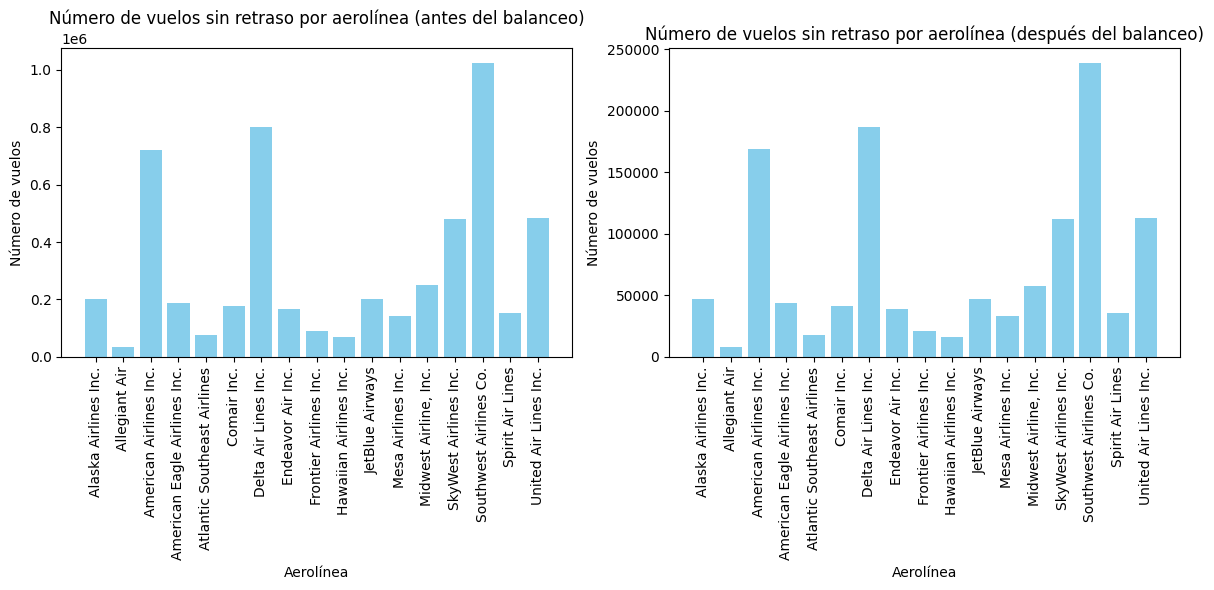

In [ ]:
# Comparamos el número de vuelos sin retraso por aerolínea antes y después del balanceo

df_no_delay = df.filter(df.DEP_DEL15 == 0)
df_no_delay_grouped = df_no_delay.groupBy("CARRIER_NAME").count().orderBy("CARRIER_NAME")
df_no_delay_pandas = df_no_delay_grouped.toPandas()

df_no_delay_balanced = df_balanced.filter(df_balanced.DEP_DEL15 == 0)
df_no_delay_balanced_grouped = df_no_delay_balanced.groupBy("CARRIER_NAME").count().orderBy("CARRIER_NAME")
df_no_delay_balanced_pandas = df_no_delay_balanced_grouped.toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(df_no_delay_pandas["CARRIER_NAME"], df_no_delay_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por aerolínea (antes del balanceo)")
plt.xlabel("Aerolínea")
plt.ylabel("Número de vuelos")
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.bar(df_no_delay_balanced_pandas["CARRIER_NAME"], df_no_delay_balanced_pandas["count"], color='skyblue')
plt.title("Número de vuelos sin retraso por aerolínea (después del balanceo)")
plt.xlabel("Aerolínea")
plt.ylabel("Número de vuelos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3. Preprocesado

#### 3.1. Creación de Pipelines según selección de características

A lo largo de la experimentación vamos a entrenar modelos con diferentes características. Las selecciones son las siguientes:

1. Todas las características
2. Solo con las características numéricas.
    - De esta forma eliminamos el coste computacional de incluír las variables categóricas, que se convierten en muchas columnas tras el OneHotEncoder
3. Características referidas al tiempo meteorológico y características categóricas.
    - Estas columnas parecen por el análisis exploratorio que pueden estar relacionadas con la variable objetivo
4. Características definida por un algoritmo de selección

Ahora ya cargamos directamente el nuevo dataset balanceado

In [22]:
# Cargamos el nuevo dataset balanceado
# df = df_balanced
df = spark.read.csv('balanced_data_flightdelay.csv', header=True, inferSchema=True)

Definimos tipos de columnas

In [9]:
# No utilizamos la variable "PREVIOUS_AIRPORT" porque tiene demasiados valores únicos
categorical_columns = ["DEP_TIME_BLK", "CARRIER_NAME", "DEPARTING_AIRPORT"]

numerical_columns = ["MONTH", "DAY_OF_WEEK", "DISTANCE_GROUP", "SEGMENT_NUMBER", "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS",
                     "AIRPORT_FLIGHTS_MONTH", "AIRLINE_FLIGHTS_MONTH", "AIRLINE_AIRPORT_FLIGHTS_MONTH", "AVG_MONTHLY_PASS_AIRPORT",
                     "AVG_MONTHLY_PASS_AIRLINE", "FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS", "PLANE_AGE", "LATITUDE", "LONGITUDE", 
                     "PRCP", "SNOW", "SNWD", "TMAX", "AWND"]

weather_columns = ["PRCP", "SNOW", "SNWD", "TMAX", "AWND"]

**1. Pipeline para cuando se usan todas las características**

Mapear las variables categóricas a numéricas usando StringIndexer

In [10]:
# Mapear las variables categóricas a numéricas usando StringIndexer
indexers = StringIndexer(inputCols=categorical_columns, outputCols=[col+"_index" for col in categorical_columns])

Convertir a vectores binarios con OneHotEncoder

In [11]:
# OneHotEncoder las variables categóricas
encoder = OneHotEncoder(inputCols=indexers.getOutputCols(), outputCols=[x + "_ohe" for x in categorical_columns])

Utilizar VectorAssembler para combinar todas las características en una sola columna de características

In [12]:
# Preparamos los datos para entrenar el modelo con todas las características
vecAssembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_columns, outputCol="features")

In [13]:
# Creamos un Pipeline con todas las etapas
pipeline = Pipeline(stages=[indexers, encoder, vecAssembler])

**2. Pipeline para cuando trabajemos solo con variables numéricas**

In [14]:
# Creamos un nuevo Pipeline para cuando trabajamos solo con variables numéricas
vecAssemblerNum = VectorAssembler(inputCols=numerical_columns, outputCol='features')
pipeline_num = Pipeline(stages=[vecAssemblerNum])

**3. Pipeline para cuando trabajemos con variables meteorológicas y categóricas**

In [15]:
vecAssembler_weather = VectorAssembler(inputCols=encoder.getOutputCols() + weather_columns, outputCol="features")
pipeline_weather = Pipeline(stages=[indexers, encoder, vecAssembler_weather])

**4. Pipeline para selección automática de características**

Utilizamos **UnivariateFeatureSelector** que es una generalización del Chi-cuadrado que 
soporta también características y clases (o etiquetas) continuas.

In [30]:
# Seleccion de variables numericas
vecAssemblerNum = VectorAssembler(inputCols=numerical_columns, outputCol='features')
selectorNum = UnivariateFeatureSelector(featuresCol='features', labelCol='DEP_DEL15', outputCol='selectedFeatures', selectionMode='numTopFeatures')
selectorNum.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(15)  

pipeline_auto = Pipeline(stages=[vecAssemblerNum, selectorNum])

#### 3.2. Separación de datos en entrenamiento y test

In [31]:
# Dividimos los datos en entrenamiento y prueba
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print(f'Tamaño del conjunto de entrenamiento: {train_data.count()}')
print(f'Tamaño del conjunto de prueba: {test_data.count()}')

Tamaño del conjunto de entrenamiento: 1964488
Tamaño del conjunto de prueba: 490612


### 4. Entrenamiento y evaluación de modelos

#### 4.1. Con el dataset balanceado

Dividir el dataset en train y test (80-20) y aplicar el Pipeline definido anteriormente (stringindexer + onehotencoder + assembler)

In [30]:
# Ejecutamos el pipeline de todas las características
pipeline_model = pipeline.fit(train_data)
train_transformed = pipeline_model.transform(train_data)
train_transformed.select("features", "DEP_DEL15").show(5)

test_transformed = pipeline_model.transform(test_data)

+--------------------+---------+
|            features|DEP_DEL15|
+--------------------+---------+
|(150,[17,22,85,12...|        1|
|(150,[17,30,64,12...|        1|
|(150,[17,20,111,1...|        1|
|(150,[17,22,74,12...|        1|
|(150,[17,19,41,12...|        1|
+--------------------+---------+
only showing top 5 rows


In [37]:
# probamos el pipeline_auto

train_transformed_selected = pipeline_auto.fit(train_data)
train_auto_transformed = train_transformed_selected.transform(train_data)
train_auto_transformed.select("selectedFeatures", "DEP_DEL15").show(5)

+--------------------+---------+
|    selectedFeatures|DEP_DEL15|
+--------------------+---------+
|[1.0,1.0,1.0,2.0,...|        1|
|[1.0,1.0,1.0,2.0,...|        1|
|[1.0,1.0,1.0,3.0,...|        1|
|[1.0,1.0,1.0,4.0,...|        1|
|[1.0,1.0,1.0,4.0,...|        1|
+--------------------+---------+
only showing top 5 rows


In [ ]:
selector_model = train_transformed_selected.stages[-1]  # si es el último stage
selected_feature_indices = selector_model.selectedFeatures
inputCols = numerical_columns
selected_columns = [inputCols[i] for i in selected_feature_indices]
print("Features seleccionadas:")
for i, col in enumerate(selected_columns, start=1):
    print(f"{i}. {col}")

Features seleccionadas:
1. MONTH
2. DISTANCE_GROUP
3. SEGMENT_NUMBER
4. CONCURRENT_FLIGHTS
5. NUMBER_OF_SEATS
6. AIRPORT_FLIGHTS_MONTH
7. AIRLINE_AIRPORT_FLIGHTS_MONTH
8. AVG_MONTHLY_PASS_AIRPORT
9. GROUND_SERV_PER_PASS
10. PLANE_AGE
11. LONGITUDE
12. PRCP
13. SNOW
14. SNWD
15. TMAX


##### 4.1.1 Entrenamiento con todas las variables menos PREVIOUS_AIRPORT

Probamos en un principio con 4 modelos típicos de clasificación binaria: 
- Regresión Logística
- Support Vector Machine (SVM)
- Árbol de Decisión
- Random Forest

In [ ]:
# Creamos el modelo de Regresión Logística sin cross-validation
lr = LogisticRegression(featuresCol='features', labelCol='DEP_DEL15')
lr_model = lr.fit(train_transformed)
predictions = lr_model.transform(test_transformed)

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

accuracy_lr = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision_lr = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
recall_lr = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
f1_score_lr = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
auc_roc_lr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

print(f'Accuracy del modelo de Regresión Logística: {accuracy_lr}')
print(f'Precisión del modelo de Regresión Logística: {precision_lr}')
print(f'Recall del modelo de Regresión Logística: {recall_lr}')
print(f'F1-score del modelo de Regresión Logística: {f1_score_lr}')

25/10/17 14:10:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/10/17 14:10:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Accuracy del modelo de Regresión Logística: 0.6179893683807163
Precisión del modelo de Regresión Logística: 0.6286106364945042
Recall del modelo de Regresión Logística: 0.5726541817825277
F1-score del modelo de Regresión Logística: 0.6171975116402888


In [ ]:
# Creamos un modelo SVM

svm = LinearSVC(featuresCol='features', labelCol='DEP_DEL15')
svm_model = svm.fit(train_transformed)
predictions_svm = svm_model.transform(test_transformed)

# Evaluamos el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

accuracy_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "accuracy"})
precision_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "precisionByLabel"})
recall_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "recallByLabel"})
f1_score_svm = evaluator.evaluate(predictions_svm, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo SVM: {accuracy_svm}')
print(f'Precisión del modelo SVM: {precision_svm}')
print(f'Recall del modelo SVM: {recall_svm}')
print(f'F1-score del modelo SVM: {f1_score_svm}')

Accuracy del modelo SVM: 0.5999037936291816
Precisión del modelo SVM: 0.6181199812894675
Recall del modelo SVM: 0.5182615942739485
F1-score del modelo SVM: 0.5972164545464509


In [ ]:
# Ahora probamos con un modelo de Árbol de Decisión

dt = DecisionTreeClassifier(featuresCol='features', labelCol='DEP_DEL15')
dt_model = dt.fit(train_transformed)
dt_predictions = dt_model.transform(test_transformed)

# Evaluamos el modelo
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "precisionByLabel"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "recallByLabel"})
dt_f1_score = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo de Árbol de Decisión: {dt_accuracy}')
print(f'Precisión del modelo de Árbol de Decisión: {dt_precision}')
print(f'Recall del modelo de Árbol de Decisión: {dt_recall}')
print(f'F1-score del modelo de Árbol de Decisión: {dt_f1_score}')

25/10/17 14:26:44 WARN MemoryStore: Not enough space to cache rdd_2496_6 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN MemoryStore: Not enough space to cache rdd_2496_3 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_3 to disk instead.
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_6 to disk instead.
25/10/17 14:26:45 WARN MemoryStore: Not enough space to cache rdd_2496_2 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_2 to disk instead.
25/10/17 14:26:45 WARN MemoryStore: Not enough space to cache rdd_2496_4 in memory! (computed 141.7 MiB so far)
25/10/17 14:26:45 WARN BlockManager: Persisting block rdd_2496_4 to disk instead.


Accuracy del modelo de Árbol de Decisión: 0.5894413508026709
Precisión del modelo de Árbol de Decisión: 0.6474935186004259
Recall del modelo de Árbol de Decisión: 0.3887431774356963
F1-score del modelo de Árbol de Decisión: 0.5722457741380327


In [ ]:
# Probamos con un modelo de Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='DEP_DEL15')
rf_model = rf.fit(train_transformed)
rf_predictions = rf_model.transform(test_transformed)

# Evaluamos el modelo
rf_accuracy = evaluator.evaluate(rf_predictions)
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "precisionByLabel"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "recallByLabel"})
rf_f1_score = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo de Random Forest: {rf_accuracy}')
print(f'Precisión del modelo de Random Forest: {rf_precision}')
print(f'Recall del modelo de Random Forest: {rf_recall}')
print(f'F1-score del modelo de Random Forest: {rf_f1_score}')

25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_1 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_6 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_6 to disk instead.
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_1 to disk instead.
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_2 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_2 to disk instead.
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_5 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_5 to disk instead.
25/10/17 14:33:14 WARN MemoryStore: Not enough space to cache rdd_2671_3 in memory! (computed 161.5 MiB so far)
25/10/17 14:33:14 WARN BlockManager: Persisting block rdd_2671_3 to disk instead.
25/10/17 14:33:14 WARN MemoryS

Accuracy del modelo de Random Forest: 0.6019268191002876
Precisión del modelo de Random Forest: 0.6246947841179874
Recall del modelo de Random Forest: 0.5205126319573814
F1-score del modelo de Random Forest: 0.6019268191002876


Ninguno parece ofrecer un buen rendimiento. Probamos con un modelo más novedoso: Gradient Boosted Trees (GBT)

In [ ]:
# Creamos un modelo de Gradient-Boosted Tree
gbt = GBTClassifier(featuresCol='features', labelCol='DEP_DEL15', maxIter=50)
gbt_model = gbt.fit(train_transformed)
gbt_predictions = gbt_model.transform(test_transformed)

# Mostramos qué variables son las más importantes
importances = gbt_model.featureImportances
feature_names = vecAssembler.getInputCols()
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("Importancia de las características en el modelo de Gradient-Boosted Tree:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

# Evaluamos el modelo
gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
gbt_precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "precisionByLabel"})
gbt_recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "recallByLabel"})
gbt_f1_score = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo de Gradient-Boosted Tree: {gbt_accuracy}')
print(f'Precisión del modelo de Gradient-Boosted Tree: {gbt_precision}')
print(f'Recall del modelo de Gradient-Boosted Tree: {gbt_recall}')
print(f'F1-score del modelo de Gradient-Boosted Tree: {gbt_f1_score}')

Importancia de las características en el modelo de Gradient-Boosted Tree:
AVG_MONTHLY_PASS_AIRPORT: 0.03744885570171575
SNOW: 0.03536439889421465
PLANE_AGE: 0.0323126130229164
AIRLINE_FLIGHTS_MONTH: 0.020900369242920797
AWND: 0.020674463047574337
FLT_ATTENDANTS_PER_PASS: 0.01513016885964901
AIRPORT_FLIGHTS_MONTH: 0.013719372459719206
SEGMENT_NUMBER: 0.012546864623695208
DEPARTING_AIRPORT_ohe: 0.012503140828539901
GROUND_SERV_PER_PASS: 0.011335978112261561
CARRIER_NAME_ohe: 0.010304645687012835
AVG_MONTHLY_PASS_AIRLINE: 0.009990565921970295
LATITUDE: 0.009843437166156844
NUMBER_OF_SEATS: 0.006822634825738881
DEP_TIME_BLK_ohe: 0.006136988203179388
CONCURRENT_FLIGHTS: 0.005588450356172626
DAY_OF_WEEK: 0.0030468025435434836
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0013176767148535323
PRCP: 0.0008520406822015806
TMAX: 0.0005700625049999596
LONGITUDE: 0.00035456960354387726
MONTH: 0.00032416924405232367
DISTANCE_GROUP: 3.983240368502452e-05
SNWD: 0.0


Accuracy del modelo de Gradient-Boosted Tree: 0.6408526493440845
Precisión del modelo de Gradient-Boosted Tree: 0.639820244513135
Recall del modelo de Gradient-Boosted Tree: 0.6409860443834363
F1-score del modelo de Gradient-Boosted Tree: 0.6408530579458551


Tabla con los resultados anteriores

In [ ]:
# Mostramos una comparación de los modelos entrenados con Pandas

results1 = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'SVM', 'Árbol de Decisión', 'Random Forest', 'Gradient-Boosted Tree'],
    'Accuracy': [accuracy_lr, accuracy_svm, dt_accuracy, rf_accuracy, gbt_accuracy],
    'Precisión': [precision_lr, precision_svm, dt_precision, rf_precision, gbt_precision],
    'Recall': [recall_lr, recall_svm, dt_recall, rf_recall, gbt_recall],
    'F1-score': [f1_score_lr, f1_score_svm, dt_f1_score, rf_f1_score, gbt_f1_score]
})
print(results1)

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.617989   0.628611  0.572654  0.617198
1                    SVM  0.599904   0.618120  0.518262  0.597216
2      Árbol de Decisión  0.589441   0.647494  0.388743  0.572246
3          Random Forest  0.601927   0.624695  0.520513  0.601927
4  Gradient-Boosted Tree  0.640853   0.639820  0.640986  0.640853


**Explicación de métricas**:
- Accuracy: Proporción de predicciones correctas sobre el total de predicciones.
- Precision: Proporción de verdaderos positivos sobre el total de positivos predichos.
- Recall: Proporción de verdaderos positivos sobre el total de positivos reales.
- F1-Score: Media armónica entre precision y recall.

En este caso, dado que las clases están balanceadas, la métrica más relevante es el Accuracy.


- **Conclusión**: 

    El mejor modelo es el de Gradient Boosted Trees (GBT) con un accuracy de 64.1%, pero no muy superior al Random Forest o a la Regresión Logística.

##### 4.1.2 Entrenamiento solo con variables numéricas

Entrenamos los cinco mismos modelos que antes pero solo con las variables numéricas

In [ ]:
# Preparamos los datos
train_transformed, test_transformed = [pipeline_num.fit(train_data).transform(df) for df in [train_data, test_data]]

# Definimos los modelos
models = {
    "Regresión Logística": LogisticRegression(featuresCol='features', labelCol='DEP_DEL15'),
    "SVM": LinearSVC(featuresCol='features', labelCol='DEP_DEL15'),
    "Árbol de Decisión": DecisionTreeClassifier(featuresCol='features', labelCol='DEP_DEL15'),
    "Random Forest": RandomForestClassifier(featuresCol='features', labelCol='DEP_DEL15'),
    "Gradient-Boosted Tree": GBTClassifier(featuresCol='features', labelCol='DEP_DEL15', maxIter=50)
}

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

# Entrenamiento, predicción y evaluación en bucle
results2 = []
for name, model in models.items():
    print(f"Entrenando {name}...")
    preds = model.fit(train_transformed).transform(test_transformed)
    metrics = {
        "Modelo": name,
        "Accuracy": evaluator.evaluate(preds, {evaluator.metricName: "accuracy"}),
        "Precisión": evaluator.evaluate(preds, {evaluator.metricName: "precisionByLabel"}),
        "Recall": evaluator.evaluate(preds, {evaluator.metricName: "recallByLabel"}),
        "F1-score": evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    }
    results2.append(metrics)

# Mostrar resultados
results_df = pd.DataFrame(results2)
print(results_df)

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.588687   0.582735  0.618386  0.588331
1                    SVM  0.587478   0.577778  0.643204  0.586208
2      Árbol de Decisión  0.592197   0.590365  0.596566  0.592191
3          Random Forest  0.595626   0.607668  0.541736  0.595626
4  Gradient-Boosted Tree  0.627127   0.622909  0.640193  0.627067


- **Conclusión**: 

    Utilizando solo las variables numéricas, el mejor modelo sigue siendo el de Gradient Boosted Trees (GBT) con un accuracy del 62.7%, ligeramente inferior al uso de todas las variables.

##### 4.1.3 Entrenamiento solo con variables meteorológicas

Entrenamos de nuevo los mismos modelos pero solo con las variables sobre el tiempo meteorológico y variables categóricas.

In [ ]:
# Preparamos los datos (solo variables meteorológicas)

train_transformed, test_transformed = [
    pipeline_weather.fit(train_data).transform(df) for df in [train_data, test_data]
]

# Definimos modelos a evaluar

models = {
    "Regresión Logística": LogisticRegression(featuresCol='features', labelCol='DEP_DEL15'),
    "SVM": LinearSVC(featuresCol='features', labelCol='DEP_DEL15'),
    "Árbol de Decisión": DecisionTreeClassifier(featuresCol='features', labelCol='DEP_DEL15'),
    "Random Forest": RandomForestClassifier(featuresCol='features', labelCol='DEP_DEL15'),
    "Gradient-Boosted Tree": GBTClassifier(featuresCol='features', labelCol='DEP_DEL15', maxIter=50)
}

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

# Entrenamiento, predicción y evaluación en bucle
results3 = []

for name, model in models.items():
    print(f"Entrenando {name}...")
    preds = model.fit(train_transformed).transform(test_transformed)

    metrics = {
        "Modelo": name,
        "Accuracy": evaluator.evaluate(preds, {evaluator.metricName: "accuracy"}),
        "Precisión": evaluator.evaluate(preds, {evaluator.metricName: "precisionByLabel"}),
        "Recall": evaluator.evaluate(preds, {evaluator.metricName: "recallByLabel"}),
        "F1-score": evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    }
    results3.append(metrics)

# Mostramos resultados finales
results3 = pd.DataFrame(results3)
print(results3)

25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_6 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_2 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_0 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN MemoryStore: Not enough space to cache rdd_3782_4 in memory! (computed 141.7 MiB so far)
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_4 to disk instead.
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_2 to disk instead.
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_0 to disk instead.
25/10/17 16:10:55 WARN BlockManager: Persisting block rdd_3782_6 to disk instead.
25/10/17 16:13:19 WARN MemoryStore: Not enough space to cache rdd_3862_7 in memory! (computed 161.5 MiB so far)
25/10/17 16:13:19 WARN BlockManager: Persisting block rdd_3862_7 to disk instead.
25/10/17 16:13:19 WARN MemoryS

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.617989   0.628611  0.572654  0.617198
1                    SVM  0.599904   0.618120  0.518262  0.597216
2      Árbol de Decisión  0.589313   0.647914  0.387326  0.571881
3          Random Forest  0.608820   0.615271  0.578329  0.608820
4  Gradient-Boosted Tree  0.641570   0.640514  0.641791  0.641571


- **Conclusión**:

    Los resultados utilizando variables meteorológicas y categóricas son muy similares a utilizando todas las variables, lo que parece indicar que las variables meteorológicas seguramente sean las más importantes de todas las variables numéricas.

    El modelo Gradient Boosted Trees (GBT) sigue siendo el mejor en terminos de accuracy.

##### 4.1.4 Entrenamiento con selección automática de características

In [ ]:
# Entrenar y transformar datos con el pipeline
train_transformed, test_transformed = [pipeline_auto.fit(train_data).transform(df) for df in [train_data, test_data]]

# Definimos los modelos en una lista
models = [
    ("Regresión Logística", LogisticRegression(featuresCol='selectedFeatures', labelCol='DEP_DEL15')),
    ("SVM", LinearSVC(featuresCol='selectedFeatures', labelCol='DEP_DEL15')),
    ("Árbol de Decisión", DecisionTreeClassifier(featuresCol='selectedFeatures', labelCol='DEP_DEL15')),
    ("Random Forest", RandomForestClassifier(featuresCol='selectedFeatures', labelCol='DEP_DEL15')),
    ("Gradient-Boosted Tree", GBTClassifier(featuresCol='selectedFeatures', labelCol='DEP_DEL15', maxIter=50))
]

# Métricas a evaluar
metric_names = ["accuracy", "precisionByLabel", "recallByLabel", "f1"]

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

# Diccionario para guardar resultados
results = {"Modelo": [], "Accuracy": [], "Precisión": [], "Recall": [], "F1-score": []}

# Entrenamiento y evaluación
for name, model in models:
    fitted_model = model.fit(train_transformed)
    predictions = fitted_model.transform(test_transformed)
    
    results["Modelo"].append(name)
    results["Accuracy"].append(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
    results["Precisión"].append(evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"}))
    results["Recall"].append(evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"}))
    results["F1-score"].append(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

# Convertimos a DataFrame de Pandas
results_df = pd.DataFrame(results)
print(results_df)

                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.585611   0.579334  0.618623  0.585167
1                    SVM  0.583999   0.572813  0.653724  0.581987
2      Árbol de Decisión  0.590701   0.592007  0.577900  0.590633
3          Random Forest  0.593387   0.596896  0.569860  0.593160
4  Gradient-Boosted Tree  0.623285   0.618875  0.637587  0.623211


- **Conclusión**: No se obtienen mejores resultados que utilizando todas las variables o solo las variables meteorológicas y categóricas.

#### 4.2. Estandarizar variables (dataset balanceado)

Los modelos SVM y Regresión Logística son sensibles a la escala de las variables, por lo que podemos probar a estandarizarlas y entrenar estos dos modelos de nuevo.

El escalado que vamos a utilizar es el **RobustScaler**, más resistente a valores atípicos que StandardScaler o MinMaxScaler.

RobustScaler centra los datos en la mediana y los escala por el rango intercuartílico, evitando que los outliers distorsionen modelos sensibles a la escala, como **regresión logística** o **SVM**, y manteniendo las relaciones relativas entre los datos.

- En nuestros datos, muchas variables numéricas presentan **valores extremos o distribuciones sesgadas, como el número de asientos, vuelos concurrentes o precipitaciones.


Solo afectará a los modelos sensibles a la escala (regresión logística y SVM). Por este motivo, en la siguiente experimentación se entrenarán solo los modelos sensibles.

##### 4.2.1 Modelo con todas las variables

Probamos a estandarizar las variables numéricas y entrenar de nuevo los modelos con todas las variables (numéricas estandarizadas + categóricas).

In [13]:
# Escalado y pipeline
scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures", withCentering=True, withScaling=True)

pipeline_scaled = Pipeline(stages=[indexers, encoder, vecAssembler, scaler])

In [14]:
train_scaled, test_scaled = [pipeline_scaled.fit(train_data).transform(df) for df in [train_data, test_data]]

In [15]:
# Modelos a evaluar (sensibles a escala)
models = {
    "Regresión Logística": LogisticRegression(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "SVM": LinearSVC(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
}

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

# Entrenamos, predecimos y evaluamos
results = []
for name, model in models.items():
    preds = model.fit(train_scaled).transform(test_scaled)
    metrics = {
        "Modelo": name,
        "Accuracy": evaluator.evaluate(preds, {evaluator.metricName: "accuracy"}),
        "Precisión": evaluator.evaluate(preds, {evaluator.metricName: "precisionByLabel"}),
        "Recall": evaluator.evaluate(preds, {evaluator.metricName: "recallByLabel"}),
        "F1-score": evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    }
    results.append(metrics)

# Resultados en tabla
print(pd.DataFrame(results))

                Modelo  Accuracy  Precisión    Recall  F1-score
0  Regresión Logística  0.586773   0.581387  0.613475  0.586484
1                  SVM  0.585487   0.576510  0.637387  0.584381


- **Conclusión**: El escalado no parece haber ofrecido mejoras significativas en los modelos sensibles a la escala.

##### 4.2.2 Modelo con las variables numéricas

Hacemos lo mismo pero entrenando solo con las variables numéricas estandarizadas.

In [16]:
vecAssembler_num = VectorAssembler(inputCols=numerical_columns, outputCol="features")

# Escalado y pipeline
scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures", withCentering=True, withScaling=True)
pipeline = Pipeline(stages=[vecAssembler_num, scaler])
train_scaled, test_scaled = [pipeline.fit(train_data).transform(df) for df in [train_data, test_data]]

In [17]:
# Modelos a evaluar
models = {
    "Regresión Logística": LogisticRegression(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
    "SVM": LinearSVC(featuresCol='scaledFeatures', labelCol='DEP_DEL15'),
}

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

# Entrenamos, predecimos y evaluamos
results = []
for name, model in models.items():
    preds = model.fit(train_scaled).transform(test_scaled)
    metrics = {
        "Modelo": name,
        "Accuracy": evaluator.evaluate(preds, {evaluator.metricName: "accuracy"}),
        "Precisión": evaluator.evaluate(preds, {evaluator.metricName: "precisionByLabel"}),
        "Recall": evaluator.evaluate(preds, {evaluator.metricName: "recallByLabel"}),
        "F1-score": evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    }
    results.append(metrics)

# Resultados en tabla
print(pd.DataFrame(results))

                Modelo  Accuracy  Precisión    Recall  F1-score
0  Regresión Logística  0.586773   0.581387  0.613475  0.586484
1                  SVM  0.585487   0.576510  0.637387  0.584381


- **Nota**: Ya no probamos con las variables meteorológicas, porque vemos que el escalado no está ofreciendo mejoras.

- **Conclusión**: La estandarización de las variables numéricas no ha mejorado los resultados de los modelos sensibles a la escala y estos continúan sin superar al modelo GBT entrenado con todas las variables o con las variables meteorológicas y categóricas.

#### 4.3 Entrenamiento de modelos con dataset desbalanceado

- **Justificación de este punto**: 

    Con ninguna de las experimentaciones anteriores hemos logrado un modelo que pase del 65% de accuracy, es por esto que hemos decidido probar a trabajar con un nuevo sampleo del dataset original, en el que mantengamos las proporciones de retrasos y no retrasos.

In [3]:
# Cargar de nuevo el dataset completo
df = spark.read.csv('full_data_flightdelay.csv', header=True, inferSchema=True)

##### 4.3.1 Nuevo muestreo del dataset original manteniendo proporciones de clases

In [4]:
# Reducimos el número de filas del dataset, pero manteniendo la proporción de vuelos con y sin retraso
# Para ello usamo stratified sampling

fractions = {0: 0.1, 1: 0.1}  # Mantener la proporción original
df_sampled = df.stat.sampleBy("DEP_DEL15", fractions, seed=42)
print('Número de filas después del muestreo estratificado:', df_sampled.count())

print("Número de vuelos con y sin retraso después del muestreo estratificado:")
print("Con retraso:", df_sampled.filter(df_sampled.DEP_DEL15 == 1).count())
print("Sin retraso:", df_sampled.filter(df_sampled.DEP_DEL15 == 0).count())

Número de filas después del muestreo estratificado: 648546
Número de vuelos con y sin retraso después del muestreo estratificado:


Con retraso: 122921


Sin retraso: 525625


In [5]:
# Calcular pesos por clase y añadir columna `classWeightCol`

# Calcular número de ejemplos por clase
class_counts = df_sampled.groupBy("DEP_DEL15").count().collect()
counts = {row["DEP_DEL15"]: row["count"] for row in class_counts}
majority = max(counts.values())
weights = {label: majority / count for label, count in counts.items()}

print("Pesos aplicados a cada clase:", weights)

# Añadir columna de pesos
df_weighted = df_sampled.withColumn("classWeightCol", when(col("DEP_DEL15") == 1, weights[1]).otherwise(weights[0]))

Pesos aplicados a cada clase: {1: 4.276120435076187, 0: 1.0}


##### 4.3.2 Nueva separación en train y test

In [6]:
# Dividimos los datos en entrenamiento y prueba
train_data, test_data = df_weighted.randomSplit([0.8, 0.2], seed=42)

print(f'Tamaño del conjunto de entrenamiento: {train_data.count()}')
print(f'Tamaño del conjunto de test: {test_data.count()}')

25/10/19 16:56:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Tamaño del conjunto de entrenamiento: 518918


Tamaño del conjunto de test: 129628


##### 4.3.3 Nueva transformación con Pipeline

In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, RobustScaler

# Columnas categóricas y numéricas
categorical_columns = ["DEP_TIME_BLK", "CARRIER_NAME", "DEPARTING_AIRPORT"]
numerical_columns = ["MONTH", "DAY_OF_WEEK", "DISTANCE_GROUP", "SEGMENT_NUMBER",
                     "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS", "AIRPORT_FLIGHTS_MONTH",
                     "AIRLINE_FLIGHTS_MONTH", "AIRLINE_AIRPORT_FLIGHTS_MONTH", "AVG_MONTHLY_PASS_AIRPORT",
                     "AVG_MONTHLY_PASS_AIRLINE", "FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS",
                     "PLANE_AGE", "LATITUDE", "LONGITUDE", "PRCP", "SNOW", "SNWD", "TMAX", "AWND"]

# Index y OHE
indexers = StringIndexer(inputCols=categorical_columns, outputCols=[c+"_index" for c in categorical_columns])
encoder = OneHotEncoder(inputCols=indexers.getOutputCols(), outputCols=[c+"_ohe" for c in categorical_columns])

# Ensamblador y escalador
vecAssembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_columns, outputCol="features")
scaler = RobustScaler(inputCol="features", outputCol="finalFeatures", withCentering=True, withScaling=True)

pipeline_weighted = Pipeline(stages=[indexers, encoder, vecAssembler, scaler])

In [8]:
pipeline_weighted_model = pipeline_weighted.fit(train_data)
train_weighted_scaled = pipeline_weighted_model.transform(train_data)
test_weighted_scaled = pipeline_weighted_model.transform(test_data)
train_weighted_scaled.select("finalFeatures", "DEP_DEL15", "classWeightCol").show(5)

+--------------------+---------+--------------+
|       finalFeatures|DEP_DEL15|classWeightCol|
+--------------------+---------+--------------+
|[0.0,0.0,0.0,0.0,...|        0|           1.0|
|[0.0,0.0,0.0,0.0,...|        0|           1.0|
|[0.0,0.0,0.0,0.0,...|        0|           1.0|
|[0.0,0.0,0.0,0.0,...|        0|           1.0|
|[0.0,0.0,0.0,0.0,...|        0|           1.0|
+--------------------+---------+--------------+
only showing top 5 rows



- **Notas**: 

    - El conjunto que se usa para entrenar los 5 modelos es el que tiene todas las características.
    - Se aplica escalado, que no afecta a DT, RF y GBT. Anteriormente parecia tampoco ayudar a obtener mejores predicciones en los metodos dependientes de escala pero, al cambiar de subconjunto de datos, volvemos a incluirlo.

#### 4.3.4 Entrenamiento de modelos con el nuevo dataset muestreado

In [ ]:
# Hacemos el entrenamiento con Regression Logística, SVM, Árbol de Decisión, Random Forest y Gradient-Boosted Tree utilizando un bucle

# Al crear los modelos, usamos el parámetro de balanceo de clases cuando sea posible

models = {
    "Regresión Logística": LogisticRegression(featuresCol='finalFeatures', labelCol='DEP_DEL15', weightCol='classWeightCol'),
    "SVM": LinearSVC(featuresCol='finalFeatures', labelCol='DEP_DEL15', weightCol='classWeightCol'),
    "Árbol de Decisión": DecisionTreeClassifier(featuresCol='finalFeatures', labelCol='DEP_DEL15', weightCol='classWeightCol'),
    "Random Forest": RandomForestClassifier(featuresCol='finalFeatures', labelCol='DEP_DEL15', weightCol='classWeightCol'),
    "Gradient-Boosted Tree": GBTClassifier(featuresCol='finalFeatures', labelCol='DEP_DEL15', weightCol='classWeightCol', maxIter=50)
}

evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
results = []

for name, model in models.items():
    print(f'Entrenando y evaluando el modelo: {name}')
    model_fitted = model.fit(train_weighted_scaled)
    predictions = model_fitted.transform(test_weighted_scaled)
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    results.append({
        "Modelo": name,
        "Accuracy": accuracy,
        "Precisión": precision,
        "Recall": recall,
        "F1-score": f1_score
    })

print(pd.DataFrame(results))

Entrenando y evaluando el modelo: Regresión Logística


Entrenando y evaluando el modelo: SVM


Entrenando y evaluando el modelo: Árbol de Decisión


Entrenando y evaluando el modelo: Random Forest


Entrenando y evaluando el modelo: Gradient-Boosted Tree


                  Modelo  Accuracy  Precisión    Recall  F1-score
0    Regresión Logística  0.588677   0.878945  0.571596  0.633284
1                    SVM  0.550714   0.876052  0.519579  0.598073
2      Árbol de Decisión  0.466064   0.887769  0.391149  0.508063
3          Random Forest  0.565511   0.875984  0.540884  0.612088
4  Gradient-Boosted Tree  0.642246   0.884430  0.642930  0.680066


- **Conclusión**: El uso del subconjunto de datos desbalanceado tampoco ofrece un rendimiento demasiado bueno. En este caso debemos fijarnos en la métrica F1-Score, ya que el accuracy puede ser engañoso en datasets desbalanceados. El mejor modelo sigue siendo el de Gradient Boosted Trees (GBT) pero con un F1-Score del 68.0%, que sigue sin ser un resultado demasiado bueno.

#### 4.3.5 Probamos nuevos modelos: MLP y Naive Bayes (dataset desbalanceado)

In [63]:
# Hacemos lo mismo que en la celda anterior pero probando modelos nuevos: MLP y Naive Bayes

scaler_minmax = MinMaxScaler(inputCol="features", outputCol="finalFeatures_nonneg")
pipeline_nonneg = Pipeline(stages=[indexers, encoder, vecAssembler, scaler_minmax])

train_final_nonneg, test_final_nonneg = [pipeline_nonneg.fit(train_data).transform(df) for df in [train_data, test_data]]

# Obtener el tamaño del vector de características para definir las capas del MLP.
# El MLP usará 'finalFeatures' (producido por pipeline_weighted)
input_size = train_weighted_scaled.select("finalFeatures").first()[0].size
# Naive Bayes usará 'finalFeatures_nonneg' (producido por pipeline_nonneg)

models = {
    "Multilayer Perceptron": MultilayerPerceptronClassifier(
        featuresCol='finalFeatures',
        labelCol='DEP_DEL15',
        layers=[input_size, 10, 5, 2],
        maxIter=100
    ),
    "Naive Bayes": NaiveBayes(
        featuresCol='finalFeatures_nonneg',
        labelCol='DEP_DEL15',
        weightCol='classWeightCol'
    )
}

evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')

results = []
for name, model in models.items():
    print(f'Entrenando y evaluando el modelo: {name}')

    if name == "Naive Bayes":
        train_final = train_final_nonneg
        test_final = test_final_nonneg
    else:
        train_final = train_weighted_scaled
        test_final = test_weighted_scaled
    
    model_fitted = model.fit(train_final)
    predictions = model_fitted.transform(test_final)
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    
    results.append({
        "Modelo": name,
        "Accuracy": accuracy,
        "Precisión": precision,
        "Recall": recall,
        "F1-score": f1_score
    })

print(pd.DataFrame(results))

Entrenando y evaluando el modelo: Multilayer Perceptron
Entrenando y evaluando el modelo: Naive Bayes
                  Modelo  Accuracy  Precisión    Recall  F1-score
0  Multilayer Perceptron  0.811406   0.812503  0.997717  0.730694
1            Naive Bayes  0.573688   0.875100  0.553372  0.619702


- **Conclusión**: 

    Obtenemos el mejor modelo hasta ahora con el MLP, con un F1-Score del 73.1%, superando al GBT.

    - En este caso debemos fijarnos en el F1-Score, ya que el dataset está desbalanceado.

##### **Extra**: Probamos MLP sobre el dataset balanceado

Al ver que el modelo de MLP ofrece buenos resultados sobre el datase desbalanceado, probamos a entrenarlo también sobre el dataset balanceado.

In [64]:
df_balanced = spark.read.csv('balanced_data_flightdelay.csv', header=True, inferSchema=True)

In [65]:
train_data, test_data = df_balanced.randomSplit([0.8, 0.2], seed=42)

train_weather_transformed = pipeline_weather.fit(train_data).transform(train_data)
test_weather_transformed = pipeline_weather.fit(train_data).transform(test_data)

In [ ]:
# Probamos MLP sobre el dataset balanceado completo
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='DEP_DEL15', layers=[train_weather_transformed.select("features").first()[0].size, 10, 5, 2], maxIter=100)

# Entrenamiento
mlp_model = mlp.fit(train_weather_transformed)

# Predicción y evaluación
mlp_predictions = mlp_model.transform(test_weather_transformed)
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15', predictionCol='prediction')
mlp_accuracy = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "accuracy"})
mlp_precision = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "precisionByLabel"})
mlp_recall = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "recallByLabel"})
mlp_f1_score = evaluator.evaluate(mlp_predictions, {evaluator.metricName: "f1"})

print(f'Accuracy del modelo MLP: {mlp_accuracy}')
print(f'Precisión del modelo MLP: {mlp_precision}')
print(f'Recall del modelo MLP: {mlp_recall}')
print(f'F1-score del modelo MLP: {mlp_f1_score}')

Accuracy del modelo MLP: 0.6146119540492283
Precisión del modelo MLP: 0.6264116344093831
Recall del modelo MLP: 0.5638052750269634
F1-score del modelo MLP: 0.6136094753404974


### 5. Experimentación final: Optimización de mejor modelo

In [16]:
# Aseguramos que el pipeline genera la columna 'features'
train_transformed = pipeline_weighted_model.transform(train_data)
test_transformed = pipeline_weighted_model.transform(test_data)

# Obtenemos el número de características de entrada
input_size = train_transformed.select("finalFeatures").first()[0].size
print(f"Número de features de entrada: {input_size}")

# Definimos el clasificador MLP
mlp = MultilayerPerceptronClassifier(featuresCol='finalFeatures', labelCol='DEP_DEL15', seed=42)

# Definimos una pequeña rejilla de hiperparámetros
paramGrid = (ParamGridBuilder()
             .addGrid(mlp.layers, [
                 [input_size, 10, 2],
                 [input_size, 15, 5, 2]
             ])
             .addGrid(mlp.maxIter, [50, 100])
             .addGrid(mlp.stepSize, [0.03, 0.1])
             .build())

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DEL15',predictionCol='prediction',metricName='f1')

# CrossValidator
crossval = CrossValidator(estimator=mlp, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, parallelism=3)

# Entrenamos el modelo con cross-validation
cv_model = crossval.fit(train_transformed)

# Recuperamos el mejor modelo
best_model = cv_model.bestModel
print("=== Mejores hiperparámetros encontrados ===")
print(f"Layers: {best_model.layers}")
print(f"MaxIter: {best_model.getMaxIter()}")
print(f"StepSize: {best_model.getStepSize()}")

# Evaluamos el modelo en el conjunto de prueba
predictions = cv_model.transform(test_transformed)

metrics = {
    "accuracy": "accuracy",
    "precision": "weightedPrecision",
    "recall": "weightedRecall",
    "f1": "f1"
}

for name, metric in metrics.items():
    value = evaluator.evaluate(predictions, {evaluator.metricName: metric})
    print(f"{name.capitalize()} del modelo MLP con CV: {value:.4f}")

Número de features de entrada: 150


25/10/19 13:43:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/10/19 13:43:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


=== Mejores hiperparámetros encontrados ===
Layers: MultilayerPerceptronClassifier_e04531ebf3c1__layers
MaxIter: 100
StepSize: 0.03


Accuracy del modelo MLP con CV: 0.8115


Precision del modelo MLP con CV: 0.7652


Recall del modelo MLP con CV: 0.8115


F1 del modelo MLP con CV: 0.7298


In [16]:
# Hacemos lo mismo del apartado anterior pero solo con las variables meteorológicas y las categóricas

train_weather_transformed = pipeline_weather.fit(train_data).transform(train_data)
test_weather_transformed = pipeline_weather.fit(train_data).transform(test_data)

# Obtenemos el número de características de entrada
input_size = train_weather_transformed.select("features").first()[0].size
print(f"Número de features de entrada (solo variables meteorológicas): {input_size}")

# Definimos el clasificador MLP
mlp_weather = MultilayerPerceptronClassifier(featuresCol='features', labelCol='DEP_DEL15', seed=42)

# Definimos una pequeña rejilla de hiperparámetros
paramGrid_weather = (ParamGridBuilder()
                .addGrid(mlp_weather.layers, [
                    [input_size, 10, 2],
                    [input_size, 15, 5, 2]
                ])
                .addGrid(mlp_weather.maxIter, [50, 100])
                .addGrid(mlp_weather.stepSize, [0.03, 0.1])
                .build())

# Evaluador
evaluator_weather = MulticlassClassificationEvaluator(labelCol='DEP_DEL15',predictionCol='prediction',metricName='f1')

# CrossValidator
crossval_weather = CrossValidator(estimator=mlp_weather, estimatorParamMaps=paramGrid_weather, evaluator=evaluator_weather, numFolds=3, parallelism=3)

# Entrenamos el modelo con cross-validation
cv_model_weather = crossval_weather.fit(train_weather_transformed)

# Recuperamos el mejor modelo
best_model_weather = cv_model_weather.bestModel
print("=== Mejores hiperparámetros encontrados ===")
print(f"Layers: {best_model_weather.layers}")
print(f"MaxIter: {best_model_weather.getMaxIter()}")
print(f"StepSize: {best_model_weather.getStepSize()}")

# Evaluamos el modelo en el conjunto de prueba
predictions_weather = cv_model_weather.transform(test_weather_transformed)

metrics_weather = {
    "accuracy": "accuracy",
    "precision": "weightedPrecision",
    "recall": "weightedRecall",
    "f1": "f1"
}

for name, metric in metrics_weather.items():
    value = evaluator_weather.evaluate(predictions_weather, {evaluator_weather.metricName: metric})
    print(f"{name.capitalize()} del modelo MLP con CV: {value:.4f}")

Número de features de entrada (solo variables meteorológicas): 134


25/10/19 17:01:15 WARN BlockManager: Block rdd_98_9 already exists on this machine; not re-adding it
25/10/19 17:01:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/10/19 17:01:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


=== Mejores hiperparámetros encontrados ===
Layers: MultilayerPerceptronClassifier_e89028b72c6c__layers
MaxIter: 50
StepSize: 0.03


Accuracy del modelo MLP con CV: 0.8109


Precision del modelo MLP con CV: 0.7339


Recall del modelo MLP con CV: 0.8109


F1 del modelo MLP con CV: 0.7272
